In [1]:
%pylab inline
from ipywidgets import interact
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


In [2]:
points = np.loadtxt("data.csv", delimiter=",").astype('float32')
points.dtype, points.shape

(dtype('float32'), (100, 2))

In [3]:
def loss(b, m, points):
    totalError = 0.0
    for x, y in points:
        totalError += (y - (m * x + b)) ** 2
    return totalError / len(points)

In [4]:
from numba import jit, float32, int64
import numba

In [5]:
# @jit("(float32, float32, float32[:,:], float32)")
@jit
def step_gradient(b_current, m_current, points, learningRate):
    b_gradient = 0.
    m_gradient = 0.
    N = len(points)
    for i in range(N): 
        x = points[i,0]
        y = points[i,1]
        b_gradient += (2.0/N) * (((m_current * x) + b_current) - y)
        m_gradient += (2.0/N) * x * (((m_current * x) + b_current) - y)
    new_b = b_current - (learningRate * b_gradient)
    new_m = m_current - (learningRate * m_gradient)
    
    return new_b, new_m

In [6]:
def gradient_descent_runner(points, initial_b, initial_m, learning_rate, num_iterations):
    b = initial_b
    b_history = []
    b_history.append(b)
    m = initial_m
    m_history = []
    m_history.append(m)
    for i in range(num_iterations):
        b,m = step_gradient(b, m, points, learning_rate)
        b_history.append(b)
        m_history.append(m)
    return np.asarray(b_history), np.asarray(m_history)

In [7]:
learning_rate = 0.00005
initial_b = 100 # initial y-intercept guess
initial_m = -8 # initial slope guess
num_iterations = 500000

In [8]:
b_history, m_history = gradient_descent_runner(points, 
                                               initial_b, 
                                               initial_m, 
                                               learning_rate, 
                                               num_iterations)

In [9]:
_b = np.linspace(-1000, 1000, 250)
_m = np.linspace(-20, 20, 250)
mesh_b, mesh_m = meshgrid(_b, _m)
mesh_loss = loss(mesh_b, mesh_m, points)
mesh_loss/=20000

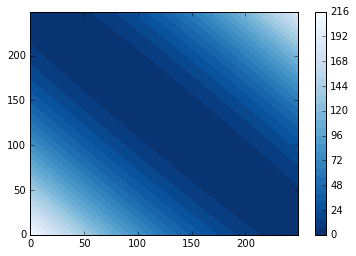

In [10]:
plt.contourf(mesh_loss, 30, cmap=plt.cm.Blues_r)
plt.colorbar()

In [11]:
from vispy import app, scene
from vispy.util.filter import gaussian_filter
from vispy.visuals.transforms import STTransform
%gui qt

canvas = scene.SceneCanvas(keys='interactive', bgcolor='k')
view = canvas.central_widget.add_view()
view.camera = scene.TurntableCamera(up='z', fov=60)

p_mesh_loss = scene.visuals.SurfacePlot(x=_b, y=_m, z=mesh_loss, color=(0.3, 0.3, 1, 0.7))
# p_mesh_loss.transform = scene.transforms.MatrixTransform()
# p_mesh_loss.transform.scale([1/500., 1/500., 1/500.])
s_optimizer = scene.visuals.Sphere(radius=2, color=(1,0,0,1))



# z = mesh_loss[1,0] - mesh_loss[0,0]
s_optimizer.transform = STTransform(translate=[10, 0, 0])


# z = np.random.normal(size=(250, 250), scale=200)
# z[100, 100] += 50000
# z = gaussian_filter(z, (10, 10))
# p1 = scene.visuals.SurfacePlot(z=z, color=(0.3, 0.3, 1, 1))
# p1.transform = scene.transforms.MatrixTransform()
# p1.transform.scale([1/249., 1/249., 1/249.])

axis = scene.visuals.XYZAxis(parent=view.scene)
view.add(p_mesh_loss)
view.add(s_optimizer)
canvas.show()

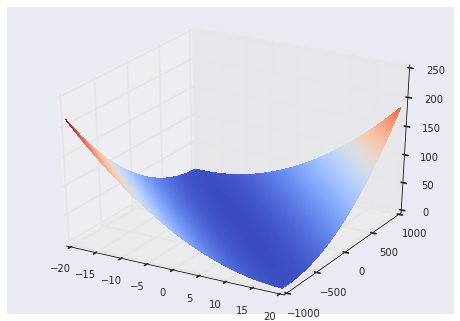

In [12]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_m, mesh_b, mesh_loss, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [13]:
mesh_loss.min(), np.unravel_index(mesh_loss.argmin(), mesh_loss.shape)

(0.0056960917169369728, (133, 125))

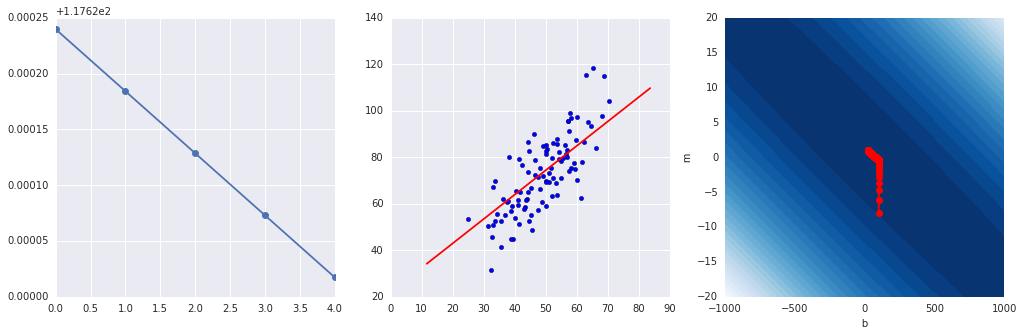

In [14]:
@interact(i=(0,num_iterations,1))
def view(i=0):
    fig, ax = plt.subplots(1,3,figsize=(17,5))
    m, b = m_history[i], b_history[i]
    x = np.linspace(min(points[:,0])-points[:,0].var()/7, max(points[:,0])+points[:,0].var()/7, 1000)
    error_history = loss(b_history[:i+1], m_history[:i+1], points)
    ax[0].plot(error_history[-5:],'-o')
    
    ax[1].scatter(points[:,0], points[:,1])
    ax[1].plot(x, m*x + b, 'r-')
    
    ax[2].plot(b_history[:i+1], m_history[:i+1],'-ro')
    ax[2].set_xlabel('b')
    ax[2].set_ylabel('m')
    ax[2].contourf(mesh_b, mesh_m, mesh_loss, 30, cmap=plt.cm.Blues_r)
    

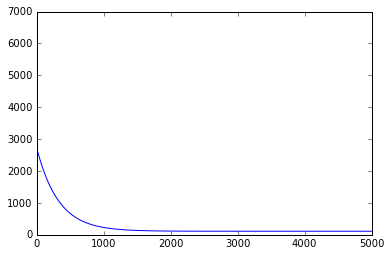

In [40]:
error_history = loss(np.asarray(b_history), np.asarray(m_history), points)
plt.plot(error_history)

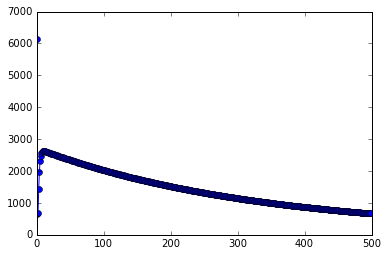

In [41]:
plt.plot(error_history[:500],'-o')

In [17]:
mesh_b = np.meshgrid(0,100,1)

In [18]:
def loss(b, m, points):
    totalError = 0.0
    for x, y in points:
        totalError += (y - (m * x + b)) ** 2
    return totalError / len(points)

In [25]:
mesh_loss = np.zeros((100,100))
for i,m in enumerate(_m):
    for j,b in enumerate(_b):
        mesh_loss[i,j] = loss(b, m, points)

In [26]:
_mesh_loss -  _mesh_loss

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

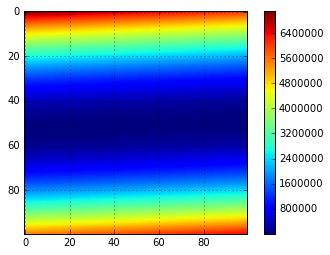

In [98]:
plt.imshow(mesh_loss)
plt.colorbar()
plt.grid('on')

In [99]:
np.unravel_index(mesh_loss.argmin(), mesh_loss.shape)

(51, 49)

In [100]:
mesh_loss[51,49]

113.93870414859057

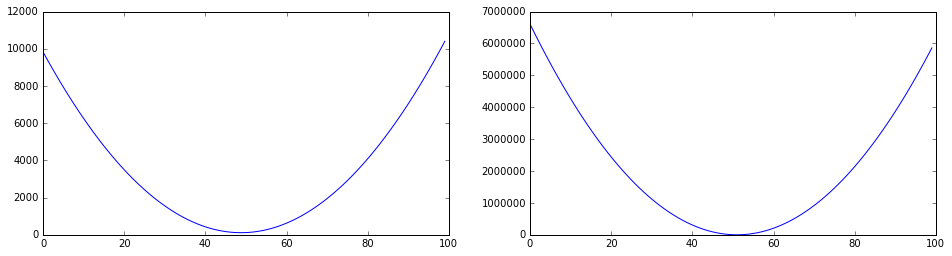

In [101]:
f,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].plot(mesh_loss[51,:])
# plt.hold(True)
ax[1].plot(mesh_loss[:,49])

In [102]:
mesh_loss[51,49]

113.93870414859057

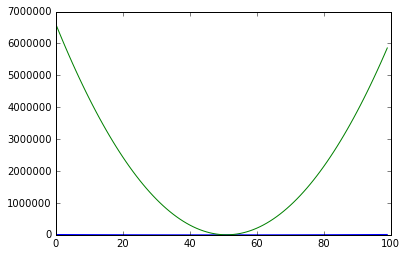

In [103]:
plot(mesh_loss[51,:])
plot(mesh_loss[:,49])

In [104]:
from mpl_toolkits.mplot3d import Axes3D

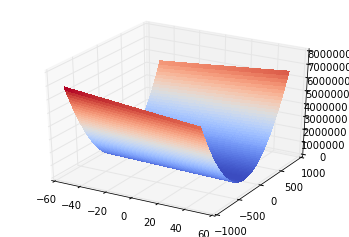

In [105]:
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(mesh_m, mesh_b, mesh_loss, rstride=1, cstride=1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# animation

In [39]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

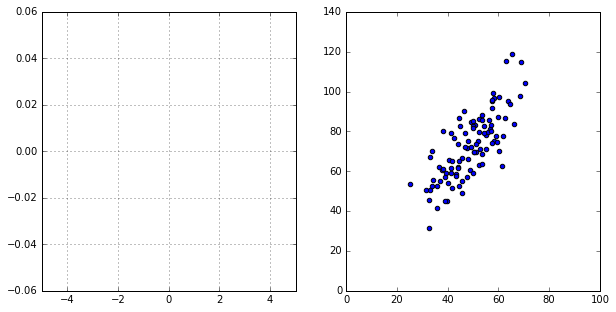

In [40]:
# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots(1, 2, figsize=(10,5))


ax[0].set_xlim((-5,5))   # m
# ax[0].set_ylim((-5,5))   # b
ax[0].grid('on')
# ax[0].set_ylim((-1,1))
ax[1].set_xlim(( 0, 100))
ax[1].set_ylim((0, 140))

params, = ax[0].plot([],[],'.')
scatter = ax[1].scatter(points[:,0], points[:,1])
line, = ax[1].plot([], [], lw=2, c='r')

In [41]:
# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    m, b = m_history[i], b_history[i]
    params.set_data(m,b)
    x = np.linspace(min(points[:,0])-points[:,0].var()/7, max(points[:,0])+points[:,0].var()/7, 1000)
    y = m*x + b
    line.set_data(x, y)
    return (line,)

In [108]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=10, blit=True)

In [109]:
anim

KeyboardInterrupt: 

In [6]:
anim.save('anim.mp4')

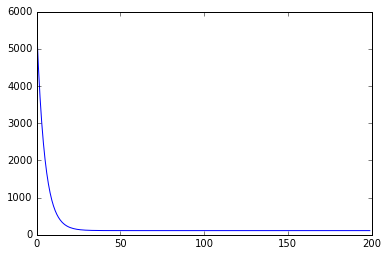

In [46]:
plt.plot(error_history[:200], '-')